#Задание с открытым ответом
##Кейс №1. Анализ данных
####Мы уже второй год живем в ситуации пандемии. За это время собрано много информации по теме заболевания COVID-19. Одним из базовых источников информации по распространению инфекции является датасет, который ведёт Университет Джона Хопкинса (https://github.com/CSSEGISandData/COVID-19). Там ведется ежедневная статистика по количеству выявленных случаев заражения, числу выздоровевших, а также числу людей, погибших от коронавируса.

####Проведите анализ данных за последний год от даты сдачи задания на проверку. Работу выполняйте в виде блокнота для Google Colab. Используя изученные на прошлых занятиях методы, проведите кластеризацию стран по показателям заболеваемости, смертности и выздоровлений за прошедшие сутки. Визуализируйте результаты. Сколько получилось кластеров? Где оказалась Россия? Сделайте выводы. Проведите аналогичный анализ для каждого из 12 предыдущих месяцев. Есть ли различие в кластерах? Если есть, то как его можно объяснить?

In [ ]:
import scipy.cluster.hierarchy as sch # для построения дендрограммы
from sklearn.cluster import AgglomerativeClustering # собственно для кластеризации
import matplotlib.pyplot as plt # для визуализации

Устанавливаем и импорттируем необходимые библиотеки

In [ ]:
!pip install tslearn==0.5.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.8/875.8 KB 10.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tslearn
import csv
import datetime
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
from tslearn.generators import random_walks
from tslearn.utils import to_time_series_dataset
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
df_confirmed = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/intermediate_certification_1/time_series_covid19_confirmed_global.csv')
df_deaths = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/intermediate_certification_1/time_series_covid19_deaths_global.csv')

In [ ]:
df_confirmed

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/19/23,2/20/23,2/21/23,2/22/23,2/23/23,2/24/23,2/25/23,2/26/23,2/27/23,2/28/23
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,209107,209153,209181,209181,209215,209230,209246,209274,209308,209322
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,334314,334315,334336,334336,334345,334356,334373,334378,334380,334391
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,271425,271426,271428,271431,271432,271436,271439,271440,271440,271441
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,47866,47866,47866,47866,47866,47866,47866,47866,47866,47866
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,105184,105184,105184,105205,105205,105205,105205,105205,105255,105255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,703228,703228,703228,703228,703228,703228,703228,703228,703228,703228
285,NaN,Winter Olympics 2022,39.904200,116.407400,0,0,0,0,0,0,...,535,535,535,535,535,535,535,535,535,535
286,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,11945,11945,11945,11945,11945,11945,11945,11945,11945,11945
287,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,342317,342724,342782,342831,342831,342831,342831,342831,342831,343012


In [ ]:
df_deaths

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/19/23,2/20/23,2/21/23,2/22/23,2/23/23,2/24/23,2/25/23,2/26/23,2/27/23,2/28/23
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,3596,3596,3596,3598,3598,3598,3598,3598,3598,3598
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,165,165,165,165,165,165,165,165,165,165
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,1931,1931,1931,1931,1931,1931,1931,1931,1933,1933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,5708,5708,5708,5708,5708,5708,5708,5708,5708,5708
285,NaN,Winter Olympics 2022,39.904200,116.407400,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
286,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,2159,2159,2159,2159,2159,2159,2159,2159,2159,2159
287,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,4051,4054,4055,4055,4055,4055,4055,4055,4055,4057


In [ ]:
# удаляем столбцы, не учавствующие в кластеризации (напр., "Country/Region")
df_confirmed = df_confirmed.drop(columns=['Country/Region'])
df_deaths = df_deaths.drop(columns=['Country/Region'])
# удаляем строку, содержащую "кумулятивные" (накопленные) данные (включ. "World")
df_confirmed = df_confirmed[df_confirmed['Province/State'].isnull()]
df_deaths = df_deaths[df_deaths['Province/State'].isnull()]
# удаляем "Province/State" (всяко-разныe "Krai", "Oblast" etc.)
df1 = df_confirmed.drop(columns=['Province/State'])   
df2 = df_deaths.drop(columns=['Province/State'])

In [ ]:
# проведем класстеризацию по странам заразившихся
X1 = df1.iloc[:, [0, 1]].values

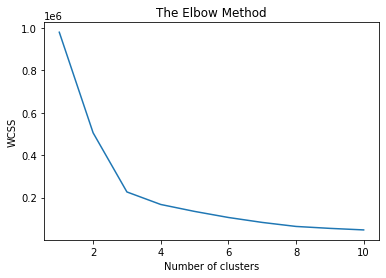

In [ ]:
# методом локтя определим количество кластеров
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X1)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
# оптимальное количество кластеров 4, но мы возьмем 6, для красоты отрисовки 6 материков
kmeans = KMeans(n_clusters = 6, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X1)
y_kmeans

array([1, 5, 5, 5, 3, 3, 0, 0, 1, 5, 1, 0, 1, 1, 0, 5, 5, 0, 3, 1, 0, 5,
       3, 0, 2, 5, 3, 2, 3, 3, 2, 3, 3, 3, 0, 0, 3, 3, 3, 0, 3, 5, 0, 1,
       5, 5, 3, 1, 0, 0, 0, 1, 0, 3, 1, 5, 3, 1, 2, 5, 5, 3, 3, 1, 5, 3,
       5, 0, 0, 3, 3, 0, 0, 5, 0, 5, 5, 1, 2, 1, 1, 5, 1, 5, 0, 2, 1, 1,
       3, 4, 2, 2, 5, 1, 1, 2, 5, 1, 3, 3, 5, 5, 5, 5, 3, 3, 3, 2, 1, 3,
       5, 2, 3, 3, 0, 2, 5, 5, 2, 5, 5, 3, 3, 2, 1, 5, 2, 0, 3, 3, 5, 5,
       1, 1, 2, 0, 2, 0, 0, 2, 5, 5, 1, 5, 2, 3, 0, 0, 0, 4, 5, 3, 1, 3,
       5, 1, 3, 2, 5, 5, 2, 1, 3, 3, 5, 1, 3, 2, 0, 5, 5, 1, 2, 1, 3, 2,
       2, 3, 4, 0, 5, 1, 2, 0, 3, 5, 1, 5, 0, 1, 2, 0, 2, 1, 2, 1, 3, 3],
      dtype=int32)

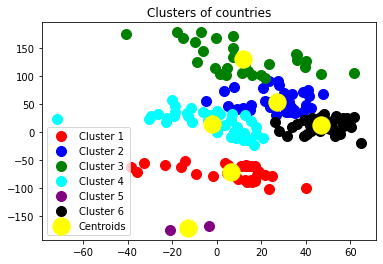

In [ ]:
plt.scatter(X1[y_kmeans == 0, 0], X1[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X1[y_kmeans == 1, 0], X1[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X1[y_kmeans == 2, 0], X1[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(X1[y_kmeans == 3, 0], X1[y_kmeans == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4')
plt.scatter(X1[y_kmeans == 4, 0], X1[y_kmeans == 4, 1], s = 100, c = 'purple', label = 'Cluster 5')
plt.scatter(X1[y_kmeans == 5, 0], X1[y_kmeans == 5, 1], s = 100, c = 'black', label = 'Cluster 6')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of countries')
plt.legend()
plt.show()

## Выше экватора определенно зараженность выше ^^^
Также играет роль и то, что количество людей выше экватора в несколько раз больше чем ниже, но это не главное.

#Разложим на класстеры зараженность стран на сегодняшний день

In [ ]:
column1 = np.arange(198).reshape((198, 1))  # создадим массив с нумерацией зараженных стран
column2 = df1.iloc[:, [-1]].values
X = np.column_stack([column1, column2])

# заранее создадим столбцы по месяцам
conf_feb = df1['1/2/22']
conf_mar = df1['1/3/22']
conf_apr = df1['1/4/22']
conf_may = df1['1/5/22']
conf_jun = df1['1/6/22']
conf_jul = df1['1/7/22']
conf_aug = df1['1/8/22']
conf_sep = df1['1/9/22']
conf_okt = df1['1/10/22']
conf_nov = df1['1/11/22']
conf_des = df1['1/12/22']
conf_jan = df1['1/1/23']

Определим количество кластеров

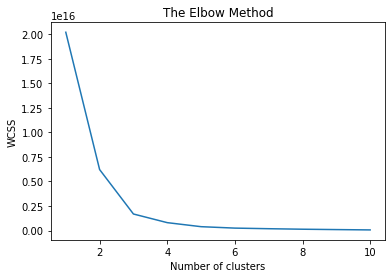

In [ ]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)
y_kmeans
# методом проб и ошибок вместо трех кластеров было выбрано 2 кластера, 
# по графику можно было выбрать 3, но оказалось это малое количество значений (Шумы)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

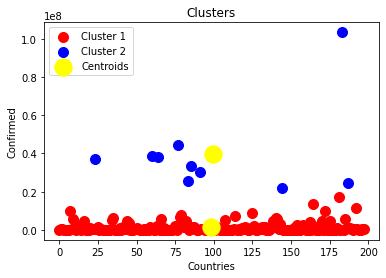

In [ ]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters')
plt.xlabel('Countries')
plt.ylabel('Confirmed')
plt.legend()
plt.show()

Россия расположилась в Первом(красном) кластере

#Разложим на кластеры смерти на сегодняшний день

In [ ]:
column2 = df2.iloc[:, [-1]].values
X = np.column_stack([column1, column2])

# Заранее создадим колонки по месяцам
death_feb = df2['1/2/22']
death_mar = df2['1/3/22']
death_apr = df2['1/4/22']
death_may = df2['1/5/22']
death_jun = df2['1/6/22']
death_jul = df2['1/7/22']
death_aug = df2['1/8/22']
death_sep = df2['1/9/22']
death_okt = df2['1/10/22']
death_nov = df2['1/11/22']
death_des = df2['1/12/22']
death_jan = df2['1/1/23']

Определим количество кластеров

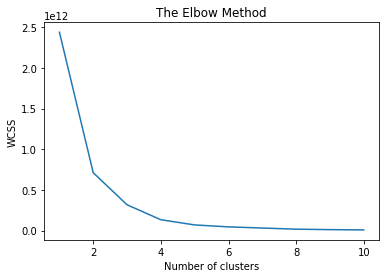

In [ ]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)
y_kmeans
# выберем 3 кластера

array([0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

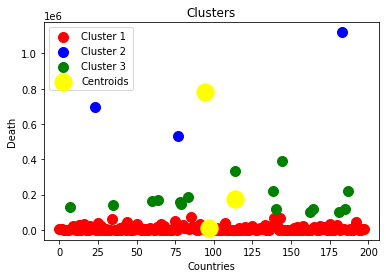

In [ ]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters')
plt.xlabel('Countries')
plt.ylabel('Death')
plt.legend()
plt.show()

#Сделаем класстеризацию Зараженности и Смертности за последние 12 месяцев

In [ ]:
df_12_conf = pd.concat([conf_feb, conf_jan], axis=1)  # Зараженность 12 месяцев
df_12_death = pd.concat([death_feb, death_jan], axis=1)  # Смертность 12 месяцев

In [ ]:
X = np.array(df_12_conf)

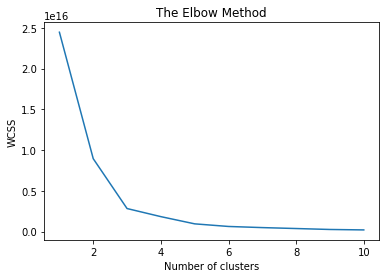

In [ ]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)
y_kmeans

array([0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0,
       0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0,
       4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, 0, 4, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0,
       0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 4,
       0, 0, 0, 0, 0, 1, 0, 2, 0, 4, 0, 1, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0],
      dtype=int32)

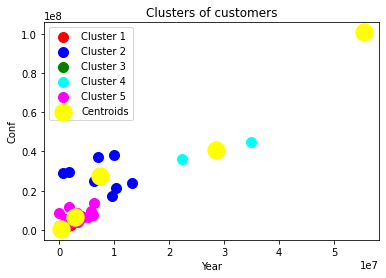

In [ ]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4')
plt.scatter(X[y_kmeans == 4, 0], X[y_kmeans == 4, 1], s = 100, c = 'magenta', label = 'Cluster 5')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of customers')
plt.xlabel('Year')
plt.ylabel('Conf')
plt.legend()
plt.show()

In [ ]:
X = np.array(df_12_death)

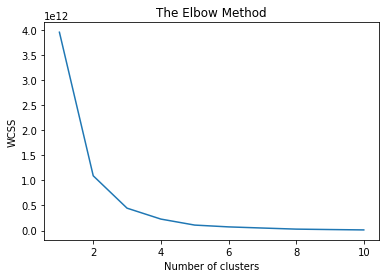

In [ ]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)
y_kmeans

array([0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 4, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

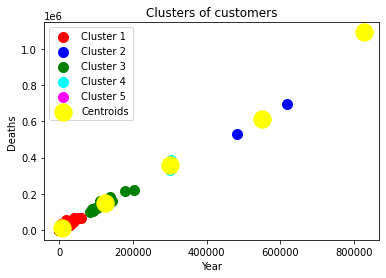

In [ ]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4')
plt.scatter(X[y_kmeans == 4, 0], X[y_kmeans == 4, 1], s = 100, c = 'magenta', label = 'Cluster 5')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of customers')
plt.xlabel('Year')
plt.ylabel('Deaths')
plt.legend()
plt.show()

#Кластеризация по Зараженным и Смертям на сегодняшний день

In [ ]:
x = df1['2/28/23']
y = df2['2/28/23']
X = pd.concat([x, y], axis=1)
X = np.array(X)

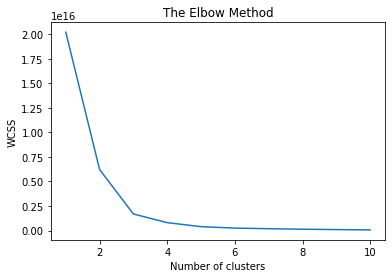

In [ ]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)
y_kmeans

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

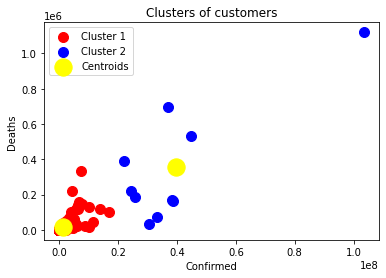

In [ ]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
# plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
# plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4')
# plt.scatter(X[y_kmeans == 4, 0], X[y_kmeans == 4, 1], s = 100, c = 'magenta', label = 'Cluster 5')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of customers')
plt.xlabel('Confirmed')
plt.ylabel('Deaths')
plt.legend()
plt.show()